In [1]:
import itertools

import awkward as ak
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from rich import print
from tabulate import tabulate

from apps.prod4a_merge_study import (BestCut, EventSelection, PFOSelection,
                                     ShowerMergeQuantities, SignalBackground,
                                     SplitSample)
from python.analysis import Master, Plots, vector

plt.style.use('ggplot')

In [16]:
def Hist2DMatrix(data : pd.DataFrame):
    nVariables = len(data.columns)
    fig, axes = plt.subplots(nrows = nVariables, ncols = nVariables, constrained_layout = True, figsize = (20, 20), dpi = 100)

    for (i, x) in enumerate(data):
        for (j, y) in enumerate(data):
            # print(f"{x} vs {y}", end = '\r')
            axes[j, i].hist2d(data[x], data[y], bins = 50)
            axes[j, i].set_xlabel(ShowerMergeQuantities.xlabels[i])
            axes[j, i].set_ylabel(ShowerMergeQuantities.xlabels[j])
            axes[j, i].label_outer()
    plt.show()

def BinnedScatter2DMatrix(data : pd.DataFrame, signal : pd.DataFrame, background : pd.DataFrame, bins = 50):
    def center(b : np.array):
        return (b[:-1] + b[1:]) / 2

    def scatter(ax, x, y, colour):
        h, xe, ye = np.histogram2d(x, y, bins = bins)
        xe = center(xe)
        ye = center(ye)

        scatter_x = []
        scatter_y = []
        scatter_z = []
        cut = 0
        for i, j in itertools.product(range(bins), repeat=2):
            if h[i, j] <= cut: continue
            scatter_x.append(xe[i])
            scatter_y.append(ye[j])
            scatter_z.append(h[i, j])
        scatter_x = np.array(scatter_x)
        scatter_y = np.array(scatter_y)
        scatter_z = np.array(scatter_z)
        ax.scatter(scatter_x, scatter_y, s = np.sqrt(bins*scatter_z), color = colour, alpha = 0.2)

    nVariables = len(data.columns)
    fig, axes = plt.subplots(nrows = nVariables, ncols = nVariables, constrained_layout = True, figsize = (20, 20), dpi = 100)
    
    for (i, x) in enumerate(data):
        for (j, y) in enumerate(data):
            x = data[ShowerMergeQuantities.selectionVariables[i]]
            y = data[ShowerMergeQuantities.selectionVariables[j]]

            x_s = x[signal]
            x_b = x[background]
            y_s = y[signal]
            y_b = y[background]

            scatter(axes[j, i], x_b, y_b, "green")
            scatter(axes[j, i], x_s, y_s, "red")
            axes[j, i].set_xlabel(ShowerMergeQuantities.xlabels[i])
            axes[j, i].set_ylabel(ShowerMergeQuantities.xlabels[j])
            axes[j, i].label_outer()
    plt.show()

def CorrelationMatrix(data : pd.DataFrame, name : str = ""):
    correlation_matrix = data.corr()
    _, ax = plt.subplots(figsize=(5.75, 5.75), dpi = 100)
    ax.set_xticks(np.arange(len(ShowerMergeQuantities.selectionVariables)), ShowerMergeQuantities.xlabels)
    ax.set_yticks(np.arange(len(ShowerMergeQuantities.selectionVariables)), ShowerMergeQuantities.xlabels)
    ax.grid(False)
    ax.imshow(correlation_matrix.values, cmap="coolwarm")

    for i, j in itertools.product(range(len(ShowerMergeQuantities.selectionVariables)), repeat=2):
        ax.text(j, i, f"{correlation_matrix.values[i, j]:.2f}", ha="center", va="center", color="w")
    plt.title(name)    
    plt.tight_layout()

def point_biserial_correlation_coefficient(x : pd.DataFrame, y : pd.DataFrame):
    """ point biserial correlation coefficient, a correlation coefficient where
        one value is discrete and the other continuous.
        https://en.wikipedia.org/wiki/Point-biserial_correlation_coefficient

    Args:
        x (pd.DataFrame): continuous variable
        y (pd.DataFrame): discrete variable

    Returns:
        pd.Series : list of correlation coefficients
    """
    # split sample into sets of values in x
    mask = y == 0
    x_0 = x[mask]
    x_1 = x[~mask]

    s_n = x.std() # standard deviation of whole sample
    # mean of sample
    m_0 = x_0.mean()
    m_1 = x_1.mean()
    # number of samples
    n_0 = len(x_0)
    n_1 = len(x_1)
    n = len(x)
    return np.sqrt(n_1*n_0/n**2) * (m_1 - m_0) / s_n


In [5]:
data = pd.read_csv("csv/merge-quantities/merge-quantities-1GeV.csv")
print(data.head())

quantities = data[ShowerMergeQuantities.selectionVariables]
signal = data["signal"]
background = data["background"]
print(quantities.head())


entry  subentry  subsubentry     alpha     delta_x    delta_xl    delta_xt  \
0      0         0            0  1.422624  445.181424   65.722565  440.303355   
1      0         0            1  1.876576  408.466058  122.963217  389.518379   
2      0         0            2  0.877978  177.341170  113.269240  136.455010   
3      0         0            3  0.689592    4.664699    3.598843    2.967784   
4      0         0            4  0.812213  191.523228  131.747700  139.009678   

   delta_phi           d           t           p  signal  background  
0   1.341801  104.693046  192.120598  194.793858   False        True  
1   1.902834  131.180941  269.834386  266.464178   False        True  
2   0.956145  134.798122  170.721787  172.676180   False        True  
3   0.273899    2.909469    3.290523    4.069478    True       False  
4   0.720936   73.710051   73.726736   74.603521   False        True

alpha     delta_x    delta_xl    delta_xt  delta_phi           d  \
0  1.422624  445.181424   65.722565  440.303355   1.341801  104.693046   
1  1.876576  408.466058  122.963217  389.518379   1.902834  131.180941   
2  0.877978  177.341170  113.269240  136.455010   0.956145  134.798122   
3  0.689592    4.664699    3.598843    2.967784   0.273899    2.909469   
4  0.812213  191.523228  131.747700  139.009678   0.720936   73.710051   

            t           p  
0  192.120598  194.793858  
1  269.834386  266.464178  
2  170.721787  172.676180  
3    3.290523    4.069478  
4   73.726736   74.603521

In [62]:
r_pb = point_biserial_correlation_coefficient(quantities, ~background)
print(r_pb.values)
print(r_pb.index)
print(tabulate(pd.DataFrame(r_pb), tablefmt="fancy_grid"))

[-0.02834535 -0.19051614 -0.09836985 -0.15965715 -0.01981157 -0.11707714
 -0.16361747 -0.15585155]

Index(['alpha', 'delta_x', 'delta_xl', 'delta_xt', 'delta_phi', 'd', 't', 'p'], dtype='object')

╒═══════════╤════════════╕
│ alpha     │ -0.0283453 │
├───────────┼────────────┤
│ delta_x   │ -0.190516  │
├───────────┼────────────┤
│ delta_xl  │ -0.0983698 │
├───────────┼────────────┤
│ delta_xt  │ -0.159657  │
├───────────┼────────────┤
│ delta_phi │ -0.0198116 │
├───────────┼────────────┤
│ d         │ -0.117077  │
├───────────┼────────────┤
│ t         │ -0.163617  │
├───────────┼────────────┤
│ p         │ -0.155852  │
╘═══════════╧════════════╛

Point biserial correlation coefficient for merge quantities wrt to signal.

Values close to zero imply no correlation. values with non-zero correlation imply that there is a relationship between the signal and that quantity, and henct you are able to loosely predict the signal depending on that particular quantity. The value with the highest discriminating power is delta_x, so this suggests a smaller value of delta can be loosely attributed to be a signal PFO. because signal is binary, the background correlations are just the values times -1.

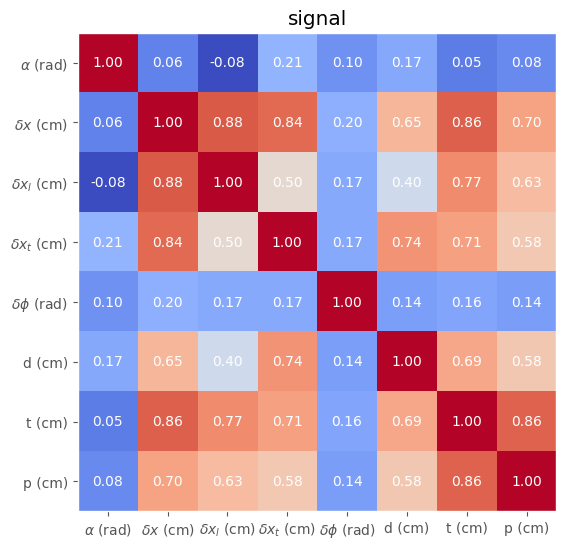

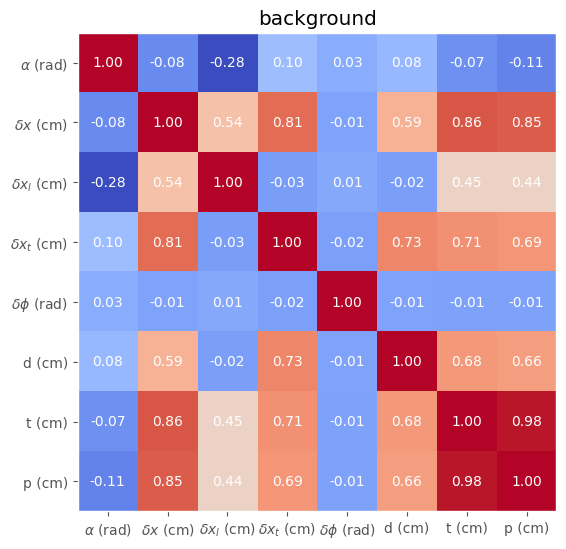

In [10]:
CorrelationMatrix(quantities[signal], "signal")
CorrelationMatrix(quantities[background], "background")

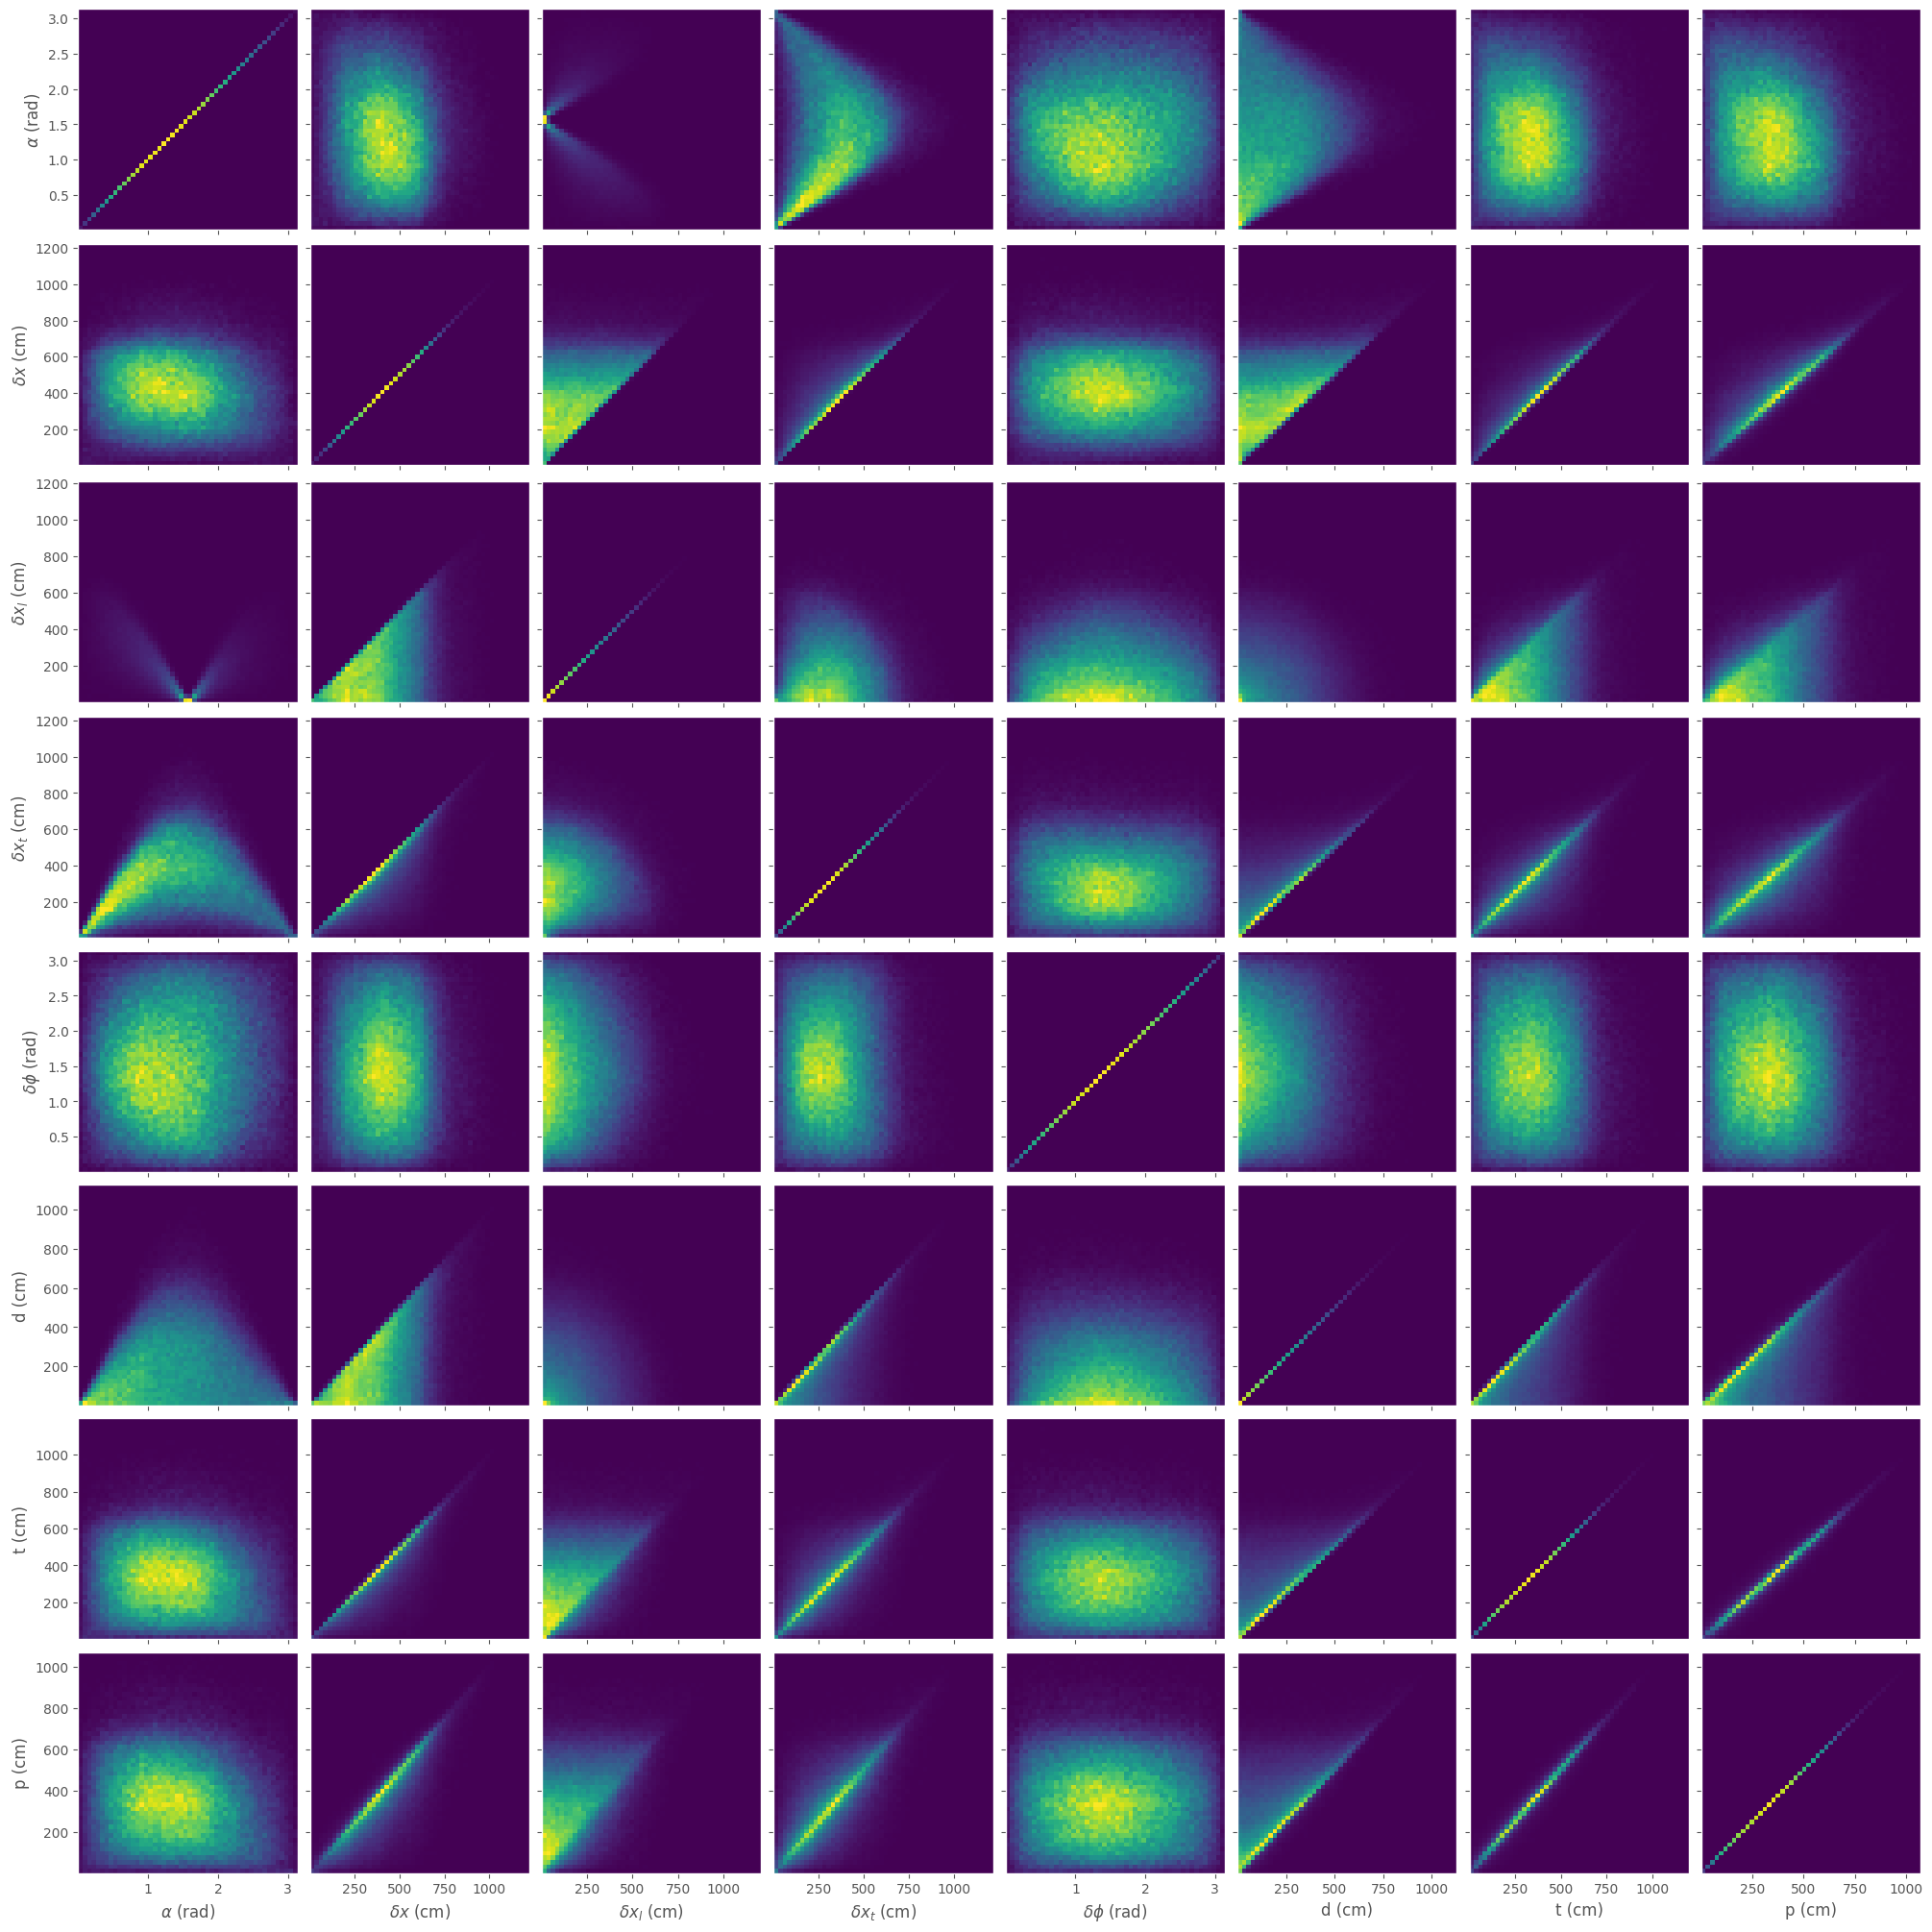

In [7]:
Hist2DMatrix(quantities)

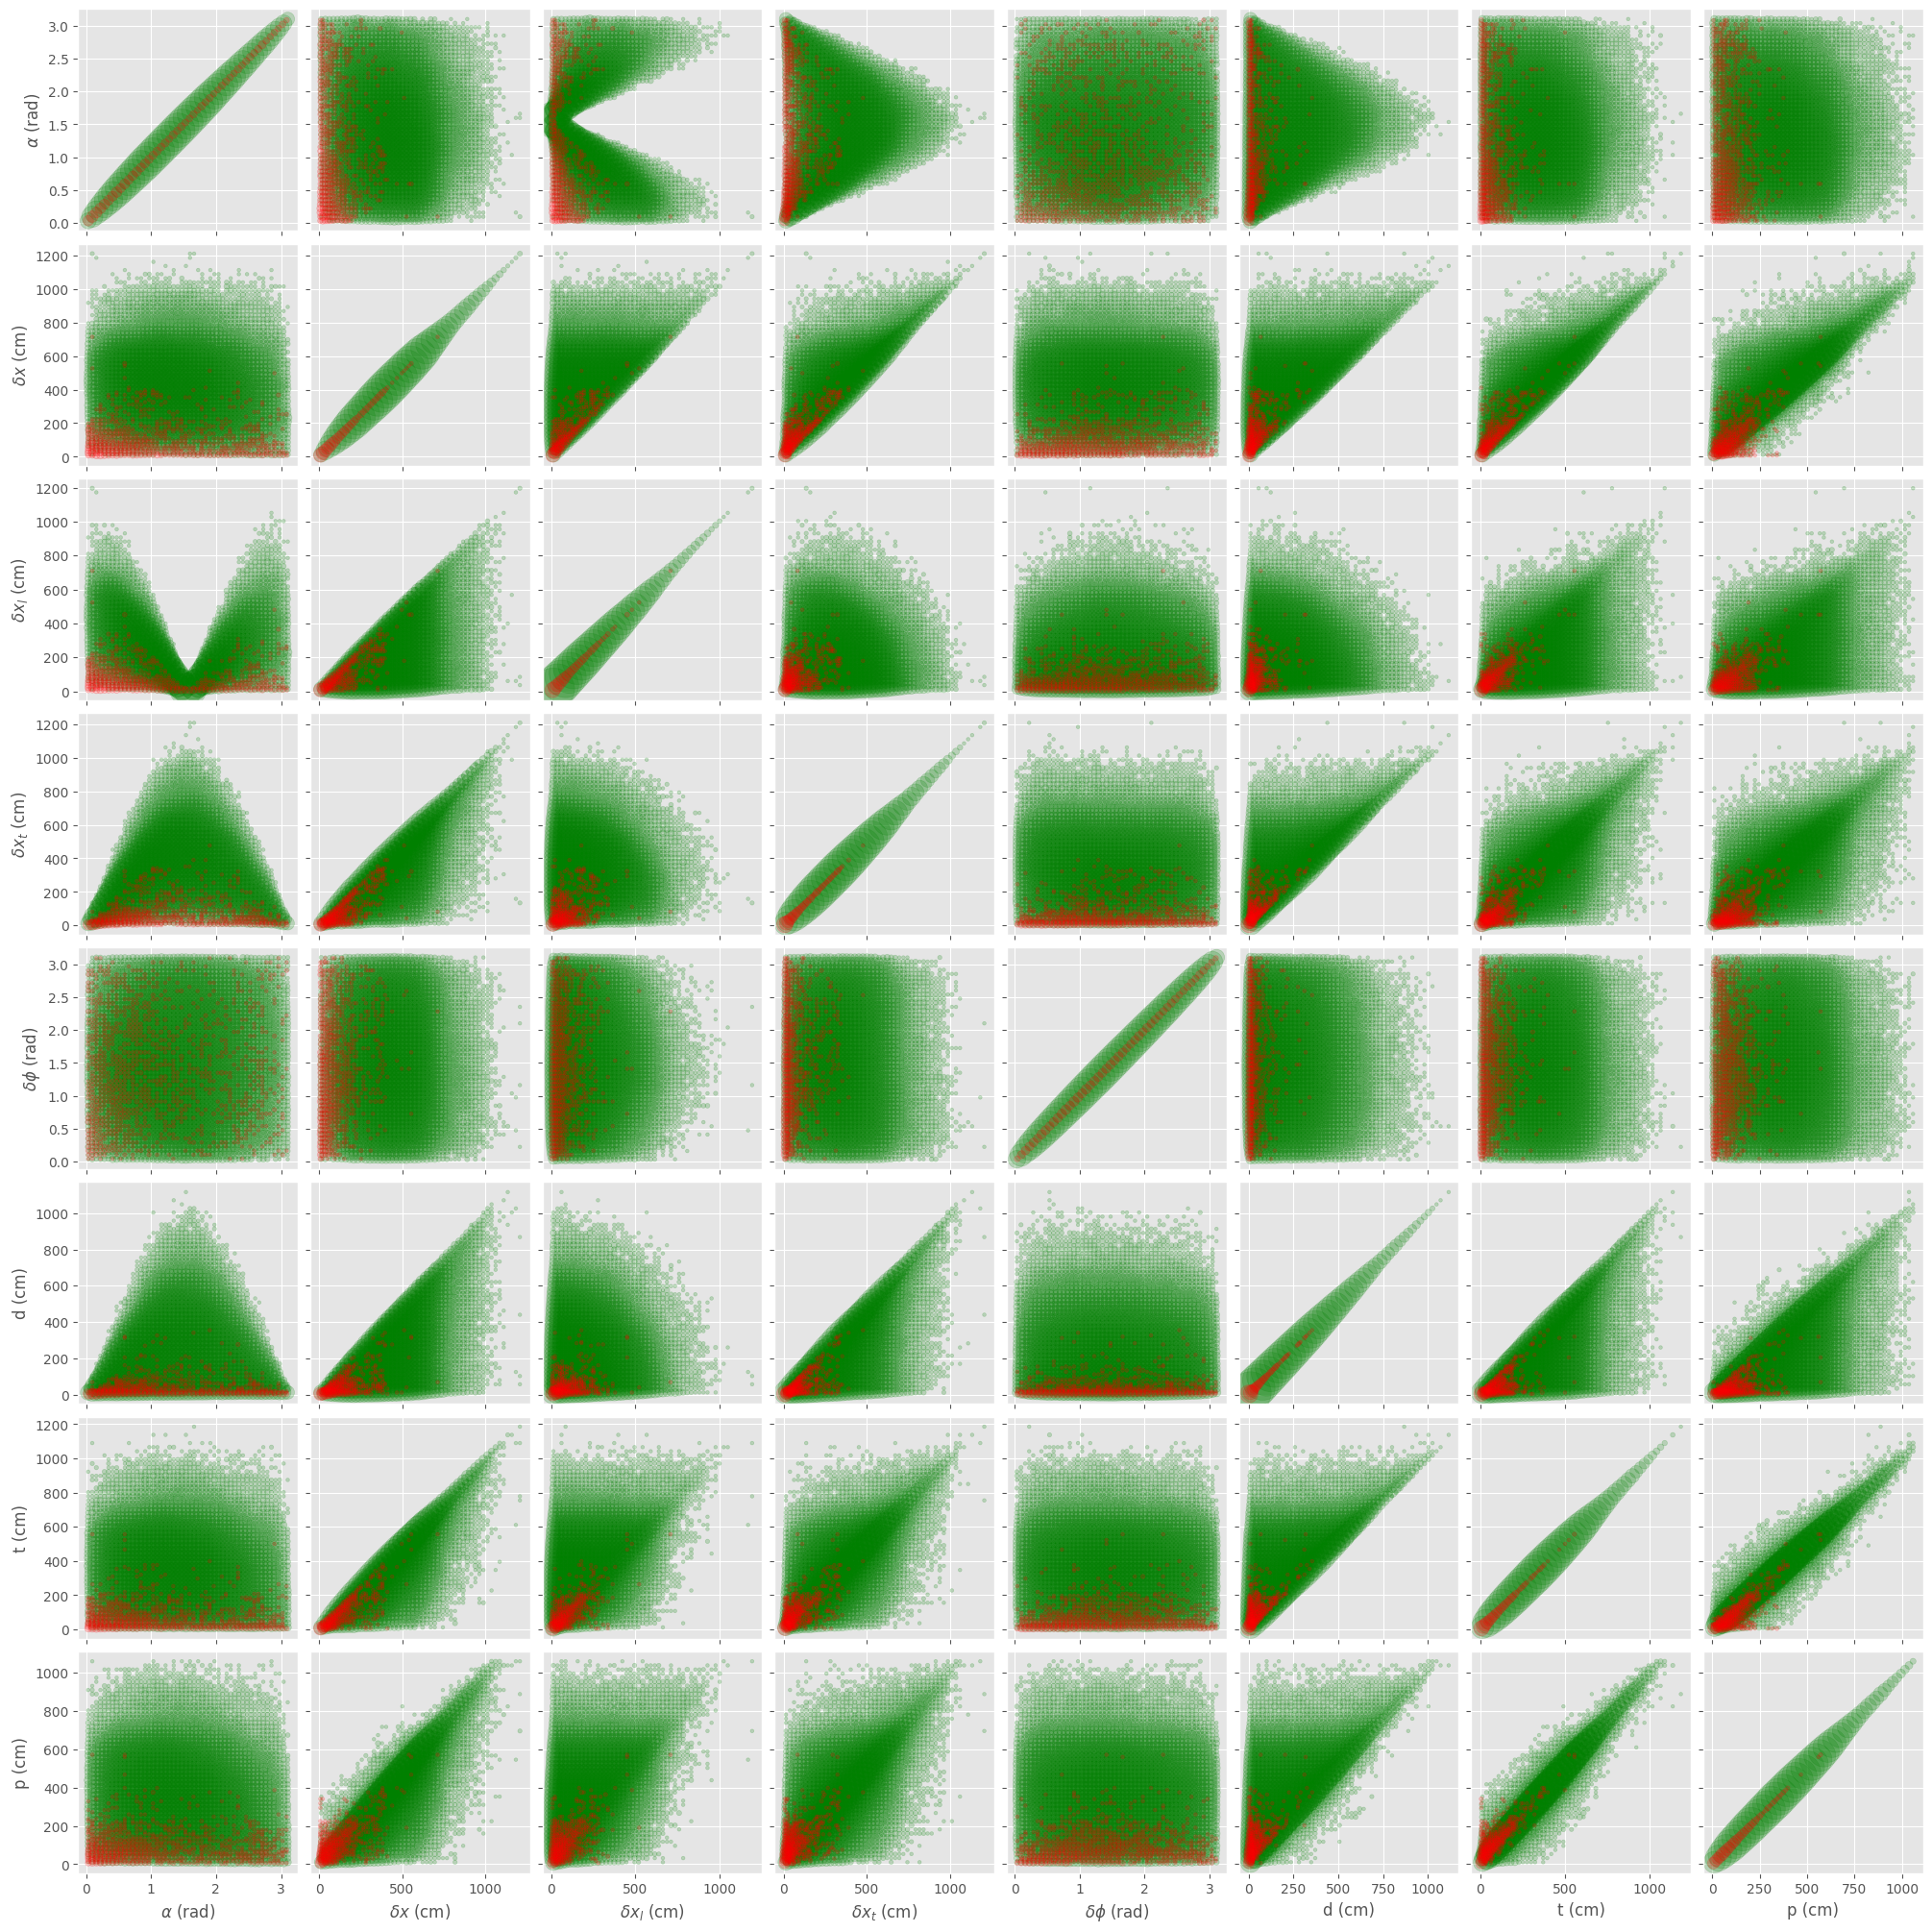

In [8]:
BinnedScatter2DMatrix(quantities, signal, background)